## Linear Regression

- Pros: Fast
- Cons: Do not capture non-linear relationship nor non-linear trends within each variable

- -> Used for quick and dirty baseline for regression

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

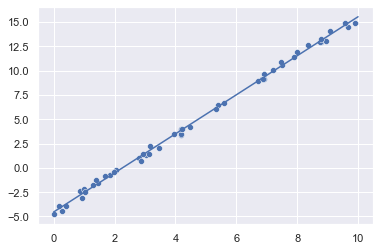

In [10]:
# Simple straight-line fits

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_theme()

# y = ax + b. a = slop // b = intercept

rng = np.random.RandomState(1)
x = 10*rng.rand(50) # Shape = (50,)
y = 2*x -5 + rng.rand(50) # Shape = (50,)
sns.scatterplot(x, y)

# Use LinearRegression estimator to fit data to the best-fit line
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
model.fit(x[:, np.newaxis], # Shape = (50, 1)
          y)

# Generate test set to plot the curve
x_test = np.linspace(0, 10, 1000)
y_model = model.predict(x_test[:, np.newaxis])
sns.lineplot(x_test, y_model)

# Multidimensional linear fit

# y = a + bx1 + cx2 + dx3 + ...

# Problem: Approach limited to strictly linear relationship between varaibles

## Basis functions

- y = a + bx1 + cx2 + dx3 + ...

Idea is to build the $x_1, x_2, x_3 ...$ from our single dimensional input $x$.
We define $x_n = f_n(x)$ where $f_n()$ is our *basis function*

For example, if $f_n(x) = x^n$, then
$y = a + bx + cx^2 + dx^3 + ...$

Note that it is still a linear model. The unkowns are the coefficients $a, b, c, d ...$ and they never multiply or divide one another.

-> We have taken our 1D data and projected them into a higher dimension

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

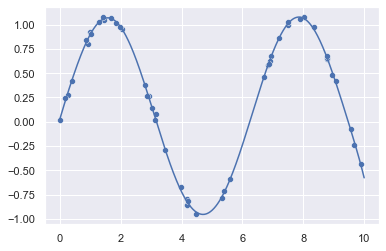

In [42]:
## Polynomial basis function

from sklearn.preprocessing import PolynomialFeatures

x = np.array([2, 3, 4]) # 1D data
poly_features = PolynomialFeatures(degree = 3, # 1D data -> 3D data
                                   include_bias=False)
poly_features.fit(x[:, np.newaxis]) # Fit to data: Compute number of ouput features (3)
X_poly = poly_features.transform(x[:, np.newaxis]) # Transform data to polynomial features

# Make a pipeline
from sklearn.pipeline import make_pipeline

# Generate data
rng = np.random.RandomState(1)
x = 10*rng.rand(50) # Shape = (50,)
y = np.sin(x) + 0.1*rng.rand(50) # Shape = (50,)
x_test = np.linspace(0, 10, 1000)

# Create our pipeline
model = make_pipeline(PolynomialFeatures(degree = 10,
                                 include_bias= False),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)
y_model = model.predict(x_test[:, np.newaxis])

sns.scatterplot(x, y)
sns.lineplot(x_test, y_model)

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


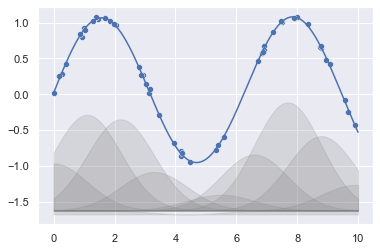

In [69]:
## Gaussian basis function

# Gaussian basis function are not implemented in Scikit-Learn -> Write a customer transformer

# Estimator: Object that fits a model based on some training data. All Estimator implemented the fit method
#            All Estimator should inherits from BaseEstimator
from sklearn.base import BaseEstimator, TransformerMixin

# Define our Gaussian basis function with mandatory methods
class GaussianFeatures(BaseEstimator, # Not necessary: provide a default implementation for the get_params() and set_params() methods
                       TransformerMixin
                      ):
    """Uniformly spaced Gaussian features for 1D input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
    @staticmethod
    def _gauss_basis(x, mu, std, axis = None):
        """Return the Gaussian probility for given x, mu and std"""
        arg = (x - mu) / std
        return np.exp(-0.5*np.sum(arg**2, axis))
    
    def fit(self, X, y=None):
        """Create N centers spread along the data range"""
        # Add '_' suffix for attributes representing best-fitted parameters
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        """Apply Gaussian function to input data"""
        return self._gauss_basis(X[:, :, np.newaxis],
                                 self.centers_,
                                 self.width_,
                                 axis = 1)
    
# Create our pipeline
# Pipeline: Sequently apply a list of transforms and a final estimator.
#           So intermediary steps must implement fit() and tranform().
#           The final estimator only needs to implement fit()
model = make_pipeline(GaussianFeatures(10, 1.0),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)
y_model = model.predict(x_test[:, np.newaxis])

fig, ax = plt.subplots()
sns.scatterplot(x, y, ax=ax)
sns.lineplot(x_test, y_model, ax=ax)

# Optional
# Extract gaussian features & linear regression model
gf = model.named_steps["gaussianfeatures"]
lm = model.named_steps["linearregression"]
# List of artificial sample to transform
xfit = np.linspace(0, 10, 1000)

for i in range(10):
    selector = np.zeros(10)
    selector[i] = 1
    Xfit = gf.transform(xfit[:, None]) * selector # Keep only the transformed sample for the ith gaussian transfomer
    yfit = lm.predict(Xfit)
    # Fill the area between two horizontal curves
    # The curves are defined by the points (*xfit*, *yfit.min()*) and (*xfit*, *yfit*)
    ax.fill_between(xfit, yfit.min(), yfit, color='gray', alpha=0.2)

# Blue curve = Sum (Gray curves)

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

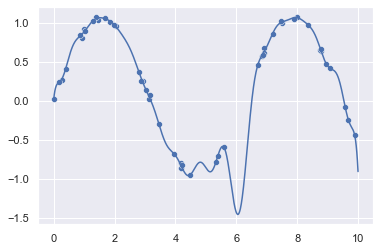

In [72]:
# Regularization:

# Basis functon makes the model much more flexible, but is can also quickly lead to over-fitting
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)
y_model = model.predict(x_test[:, np.newaxis])

sns.scatterplot(x, y)
sns.lineplot(xfit, y_model)

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

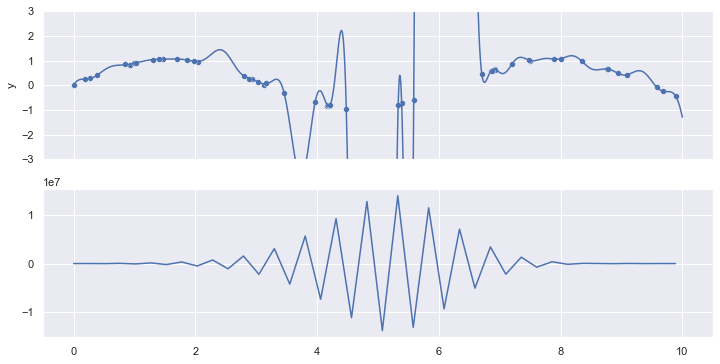

In [103]:
# Vizualise model coefficient

def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, figsize = (12, 6),
                           sharex = True)
    
    model.fit(x[:, np.newaxis], y)
    y_model = model.predict(xfit[:, np.newaxis])
    # Plot the dataset and model curve
    sns.scatterplot(x, y, ax=ax[0])
    sns.lineplot(xfit, y_model, ax=ax[0])
    ax[0].set(xlabel='x', ylabel='y', ylim=(-3, 3))
    
    if title:
        ax[0].set_title(title)
        
    # Plot the linear coefficients
    gauss_centers = model.steps[0][1].centers_, # Extract the attribute centers_ from the Gaussian transformer
    linear_coeffs = model.steps[1][1].coef_, # Extract the attribute coefs_ from the Linear Regression
    sns.lineplot(gauss_centers[0], linear_coeffs[0], ax=ax[1])
    
model = make_pipeline(GaussianFeatures(40),
                      LinearRegression())
basis_plot(model)

# Overfitting: The coefficiant of adjacent basis function blow up and cancer each other out (1'000, then -1'000)
# Solution = Regularization: Limit spikes in the model by penalizing large values of the model parameters

##### Regularization

- Most common form of regularization is the "ridge regression" = "L2 regularization"

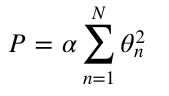

$\alpha$ : Free parameter that controls the strenght of the penality

$\theta_i$: Model coefficients

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarnin

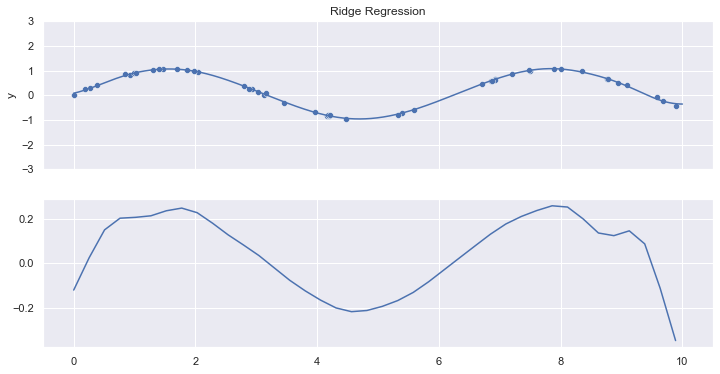

In [105]:
## Regularization: L2
from sklearn.linear_model import Ridge
# Pros: Almost as fast as LinearRegression

model = make_pipeline(GaussianFeatures(40),
                      Ridge(alpha = 0.1) # Loss function = Linear Model + R2 regularization
                     )
basis_plot(model, title = "Ridge Regression")

#### Regularization: L1

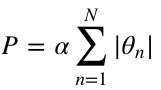

- Tends to set model coefficients to exactly 0 more often than L2 regularization -> Only a subset of basis functions active

/Users/nicolas/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-p

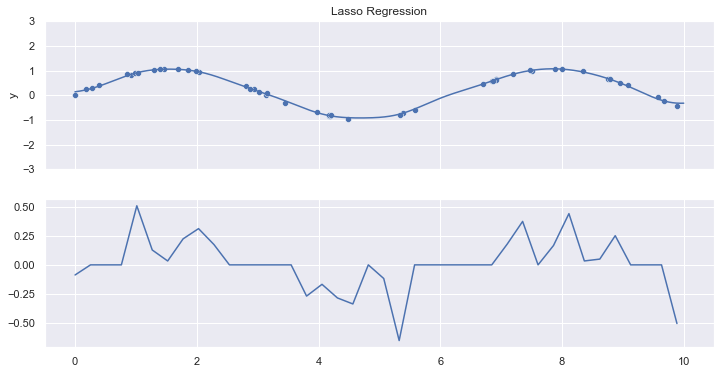

In [112]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(40),
                      Lasso(alpha = 0.001))
basis_plot(model, title = 'Lasso Regression')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2725k    0 2725k    0     0   617k      0 --:--:--  0:00:04 --:--:--  636k


In [162]:
## Example: Prediction Bicyle traffic

# Load datasets: traffic + weather
import pandas as pd

# !curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD
counts = pd.read_csv('FremontBridge.csv', # Hourly traffic from 2012 to 2022
                     index_col='Date', # Daily weather from 2012 to 2015
                     parse_dates=True)
weather = pd.read_csv('../data/BicycleWeather.csv',
                      index_col='DATE',
                      parse_dates=True)

display(counts.head(1))
display(weather.head(1))

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2022-08-01,23.0,7.0,16.0


,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2012-01-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,0,0,0,128,50,47,100,90,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999


In [163]:
# Compute total daily bicycle traffic
daily = counts.resample('d').sum() # Transform Hourly frequenty to Daily Frequency (sum of hourly records for 1 day)
daily["Total"] = daily.sum(axis=1) # Compute traffic sum of each corridor
daily = daily[["Total"]]

# Add weekday traffic indicator
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(len(days)):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)
# Add holidays indicator
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016') # Return DatimeIndex containing holydays only
daily = daily.join(pd.Series(1, index=holidays, name = 'holiday')) # Combine the 2 pandas objects based on the index
daily["holiday"].fillna(0, inplace=True)
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  after removing the cwd from sys.path.
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Date', ylabel='daylight_hrs'>

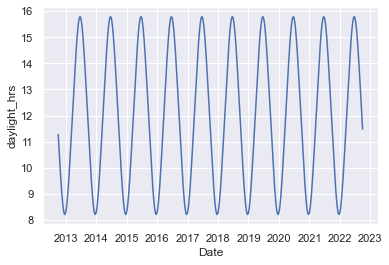

In [164]:
# Add hours of daylight feature
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date in Seattle"""
    days = (date - pd.datetime(2000, 12, 21)).days # Get timedelta
    # Standard astronomical calculation
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily["daylight_hrs"] = list(map(hours_of_daylight, # function
                                 daily.index # Iterable
                                 ))
sns.lineplot(daily.index, daily.daylight_hrs)
    

In [165]:
# Add temperature and precipitation features
# Convert to Celsius
weather["TMIN"] /= 10
weather["TMAX"] /= 10
weather["Temp (C)"] = 0.5 * (weather['TMIN'] + weather['TMAX']) # Temperature average

# Convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

# Add weather features to daily dataframe
daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']])

# Add annual counter from day 1
daily['annual'] = (daily.index - daily.index[0]).days / 365
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,7042.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,13.35,1.0,0.000000
2012-10-04,6950.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,13.60,1.0,0.002740
2012-10-05,6296.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,15.30,1.0,0.005479
2012-10-06,4012.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,15.85,1.0,0.008219
2012-10-07,4284.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,15.85,1.0,0.010959


In [179]:
# Remove sample if any feature is missing
daily.dropna(axis=0, how='any', inplace=True)

# Define dataset
feature_cols = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[feature_cols]
y = daily['Total']

# Fit LinearRegression model to data
model = LinearRegression(fit_intercept=False) # Set y-intercept to 0
model.fit(X, y) # BAD: Training set also used for prediction
daily['predicted'] = model.predict(X)

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/nicolas/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  


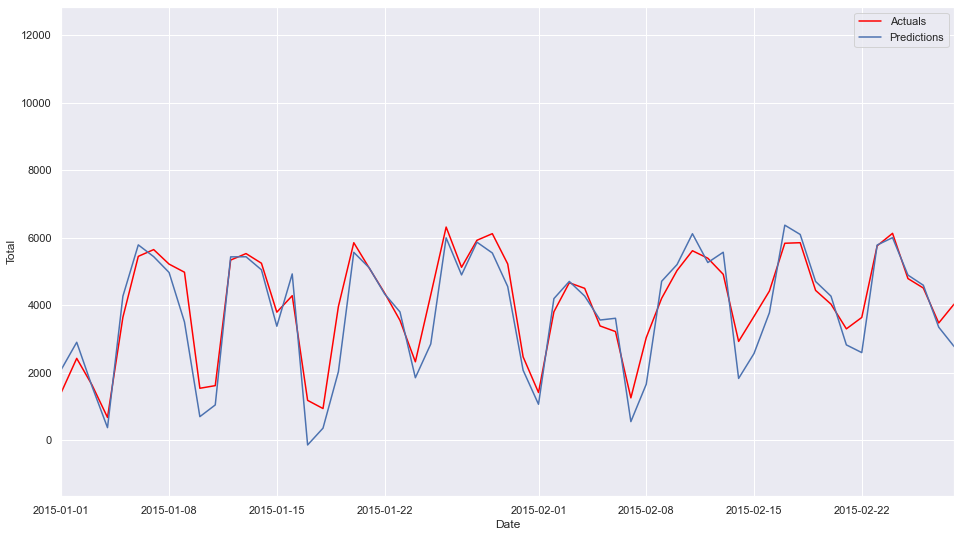

In [193]:
# Vizualise bicycle traffic actual vs. prediction
fig, ax = plt.subplots(figsize = (16, 9))

sns.lineplot(daily.index,
             daily.Total,
             label = 'Actuals',
             color = 'red',
             ax=ax)
sns.lineplot(daily.index,
             daily.predicted,
             label = 'Predictions',
             ax=ax)
# On 2 months only
ax.set(xlim = (pd.datetime(2015, 1, 1), pd.datetime(2015, 2, 28)));

In [217]:
# How much each feature contributes to the to the bicycle counts
params = pd.Series(model.coef_, index=X.columns)
params

# Meaning: +1 daylight adds 257.70 riders
# Let's compute the std for each feature

from sklearn.utils import resample
np.random.seed(1)
# Compute the standard deviation along a specific axis.
# Simulate 1'000 simulation and see how stable each coeffient is
# For each simulation, resample the dataset to get a different model
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], 0)

pd.DataFrame({"effect": params.round(0),
              "error": err.round(0)})

# Meaning: +1 daylight adds 253+/-18 riders
#          +38+/-35 new daily rider each day

,effect,error
Mon,1119.0,173.0
Tue,1243.0,166.0
Wed,1306.0,166.0
Thu,958.0,170.0
Fri,401.0,162.0
Sat,-2144.0,159.0
Sun,-2329.0,166.0
holiday,-2481.0,326.0
daylight_hrs,253.0,18.0
PRCP,-1244.0,125.0


#### Concept Summary

- Straight-line + Multidimensional linear fit
- Basis function:
    - Polynomial basis function: $y = a + bx + cx^2 + dx^3 + ...$
    - Gaussian basis function $y = a + bGaus(x, mu = x.min(), std = 0) + cGaus(x, mu = x.min() + 1, std = 0) + ... + zGaus(x, mu = x.max(), std = 0)$
- Regularization: Limit spikes in the model by penalizing large values of the model parameters.
    - $L_2$ Regularization
    - $L_1$ Regularization: Tend to set coefficient to exactly 0 more frequently